In [75]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, Multiply, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from fireflyalgorithm import FireflyAlgorithm
from keras.layers import LSTM, Attention
from keras.optimizers import Adam

In [76]:
# Load MSRP data
data = pd.read_csv('msr_paraphrase_train.csv', on_bad_lines='skip')
sentences1 = data['#1 String'].fillna("").astype(str).values
sentences2 = data['#2 String'].fillna("").astype(str).values
labels = data['Quality'].values

# Tokenize sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(sentences1) + list(sentences2))
sequences1 = tokenizer.texts_to_sequences(sentences1)
sequences2 = tokenizer.texts_to_sequences(sentences2)
max_len = 20
padded_sequences1 = pad_sequences(sequences1, maxlen=max_len, padding='post')
padded_sequences2 = pad_sequences(sequences2, maxlen=max_len, padding='post')

# Split into train and test sets
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(
    padded_sequences1, padded_sequences2, labels, test_size=0.2, random_state=42
)

# Load Word2Vec embeddings
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
# word2vec = api.load("word2vec-google-news-300")
embedding_dim = word2vec.vector_size
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

print(f"Tokenizer vocabulary size: {len(tokenizer.word_index)}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"X_train1 shape: {X_train1.shape}, X_train2 shape: {X_train2.shape}, y_train shape: {y_train.shape}")

Tokenizer vocabulary size: 13678
Embedding matrix shape: (13679, 300)
X_train1 shape: (3150, 20), X_train2 shape: (3150, 20), y_train shape: (3150,)


In [88]:
# Firefly algorithm parameters
population_size = 10
max_generations = 10
gamma = 1.0  # Light absorption coefficient
alpha = 0.5  # Step size factor for randomness
beta_base = 1.0  # Base attractiveness

# Define the CNN model with hybrid attention mechanism (LSTM + Attention)
def build_model(max_len, embedding_matrix):
    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))
    
    # Embedding Layer
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                output_dim=embedding_matrix.shape[1],
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=False)
    
    embedded_1 = embedding_layer(input_1)
    embedded_2 = embedding_layer(input_2)
    
    # LSTM Layer
    lstm_layer = LSTM(128, return_sequences=True)
    lstm_1 = lstm_layer(embedded_1)
    lstm_2 = lstm_layer(embedded_2)
    
    # Attention Layer
    attention_layer = Attention()
    attention_output_1 = attention_layer([lstm_1, lstm_1])  # Self-attention
    attention_output_2 = attention_layer([lstm_2, lstm_2])  # Self-attention
    
    # Weighted sum of attention outputs
    attended_1 = Multiply()([lstm_1, attention_output_1])
    attended_2 = Multiply()([lstm_2, attention_output_2])
    
    # Global Max Pooling
    pooled_1 = GlobalMaxPooling1D()(attended_1)
    pooled_2 = GlobalMaxPooling1D()(attended_2)
    
    # Concatenate and Dense Layer
    concatenated = Concatenate()([pooled_1, pooled_2])
    dense_1 = Dense(64, activation='relu')(concatenated)
    similarity_score = Dense(1, activation='sigmoid')(dense_1)
    
    model = Model(inputs=[input_1, input_2], outputs=similarity_score)
    return model

def compute_text_quality(y_true, y_pred):
    y_pred_classes = np.round(y_pred).astype(int)  # Convert predictions to binary
    return accuracy_score(y_true, y_pred_classes)

def compute_frame_rate(model, input_data):
    start_time = time.time()
    _ = model.predict(input_data, batch_size=32)  # Adjust batch size as needed
    end_time = time.time()
    elapsed_time = end_time - start_time
    return len(input_data[0]) / elapsed_time  # Assuming input_data[0] is a batch

metrics_log = {
    'iterations': [],
    'text_quality': [],
    'frame_rate': [],
    'Counter_text': []
}

# Generate initial population of models (fireflies)
def initialize_population(population_size, max_len, embedding_matrix):
    population = []
    for _ in range(population_size):
        model = build_model(max_len, embedding_matrix)
        population.append(model)
    return population

# Evaluate the fitness of each model in the population
def evaluate_population(population, X_train1, X_train2, y_train):
    fitness = []
    for i, model in enumerate(population):
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit([X_train1, X_train2], y_train, batch_size=32, epochs=1, verbose=0)
        loss = history.history['loss'][-1]  # Take last loss value
        fitness.append(loss)
        
        y_pred = model.predict([X_train1, X_train2])
        text_quality = compute_text_quality(y_train, y_pred)
        frame_rate = compute_frame_rate(model, [X_train1, X_train2])
        
        # Log metrics
        metrics_log['iterations'].append(i + 1)
        metrics_log['text_quality'].append(text_quality)
        metrics_log['Counter_text'].append(text_quality)
        metrics_log['frame_rate'].append(frame_rate)
        print(f"Iteration {i + 1}: Text Quality = {text_quality:.4f}, Frame Rate = {frame_rate:.2f} fps")
    return fitness

# Firefly optimization algorithm
# Assuming your FireflyAlgorithm accepts seed and other parameters
def firefly_optimization(population, X_train1, X_train2, y_train, max_generations, beta_base, gamma, alpha):
    firefly_algorithm = FireflyAlgorithm(population_size, gamma, alpha, beta_base, seed=42)  # Using an integer seed
    for generation in range(1):
        # for generation in range(5):
        fitness = evaluate_population(population, X_train1, X_train2, y_train)  # Evaluate fitness
        # Firefly algorithm's specific operations
        for i in range(len(population)):
            for j in range(len(population)):
                if fitness[j] < fitness[i]:  # If firefly j is more attractive
                    distance = np.linalg.norm(fitness[i] - fitness[j])
                    move_firefly(population[i], population[j], beta_base, gamma, distance, alpha)
            
        # Output the results
        print(f"Generation {generation+1}/{max_generations}, Best Loss: {min(fitness)}")
    best_index = np.argmin(fitness)
    return population[best_index]


In [89]:
print(X_train1.shape)  # Should output something like (3150, ...)
print(X_train2.shape)  # Should output something like (3150, ...)
print(y_train.shape)   # Should output (3150,) or (3150, 1)

(3150, 20)
(3150, 20)
(3150,)


In [90]:
population = initialize_population(population_size, max_len, embedding_matrix)
best_model = firefly_optimization(population, X_train1, X_train2, y_train, max_generations, beta_base, gamma, alpha)
loss, accuracy = best_model.evaluate([X_test1, X_test2], y_test)
print(f'Best Model Test Loss: {loss:.4f}')
print(f'Best Model Test Accuracy: {accuracy:.4f}')

C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1716', 'keras_tensor_1717']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 1: Text Quality = 0.6832, Frame Rate = 2574.85 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1731', 'keras_tensor_1732']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Iteration 2: Text Quality = 0.7041, Frame Rate = 2667.94 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1746', 'keras_tensor_1747']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 3: Text Quality = 0.7029, Frame Rate = 2657.04 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1761', 'keras_tensor_1762']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Iteration 4: Text Quality = 0.6832, Frame Rate = 2805.34 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1776', 'keras_tensor_1777']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 5: Text Quality = 0.6952, Frame Rate = 2536.67 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1791', 'keras_tensor_1792']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 6: Text Quality = 0.6889, Frame Rate = 2704.00 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1806', 'keras_tensor_1807']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Iteration 7: Text Quality = 0.6917, Frame Rate = 2972.51 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1821', 'keras_tensor_1822']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 8: Text Quality = 0.6832, Frame Rate = 2625.14 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1836', 'keras_tensor_1837']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Iteration 9: Text Quality = 0.6914, Frame Rate = 3024.92 fps


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1851', 'keras_tensor_1852']. Received: the structure of inputs=('*', '*')
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Iteration 10: Text Quality = 0.6959, Frame Rate = 2829.49 fps
Generation 1/10, Best Loss: 0.6108026504516602


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1851', 'keras_tensor_1852']. Received: the structure of inputs=('*', '*')
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6661 - loss: 0.6222
Best Model Test Loss: 0.6249
Best Model Test Accuracy: 0.6675


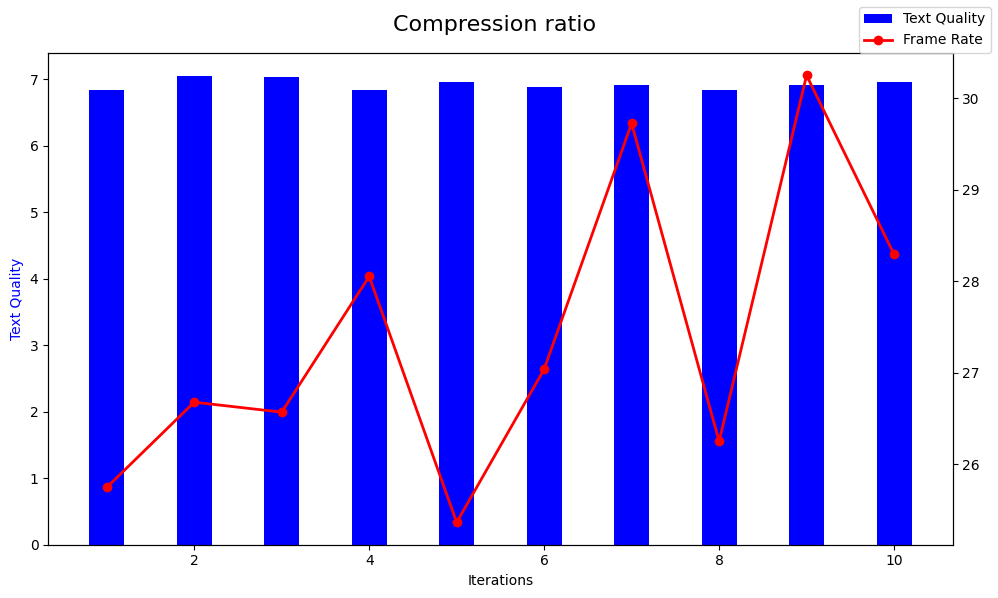

In [92]:
# Use the metrics logged during training
iterations = metrics_log['iterations']
text_quality = metrics_log['text_quality']
frame_rate = metrics_log['frame_rate']
text_quality = [n*10 for n in text_quality]
frame_rate = [n/100 for n in frame_rate]

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar chart for text quality
bar_width = 0.4
bars = ax1.bar(iterations, text_quality, bar_width, color='blue', label='Text Quality')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Text Quality', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin axis for the line chart
ax2 = ax1.twinx()
ax2.plot(iterations, frame_rate, color='red', marker='o', linestyle='-', linewidth=2, label='Frame Rate')

# Add a title and legend
fig.suptitle('Compression ratio', fontsize=16)
fig.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


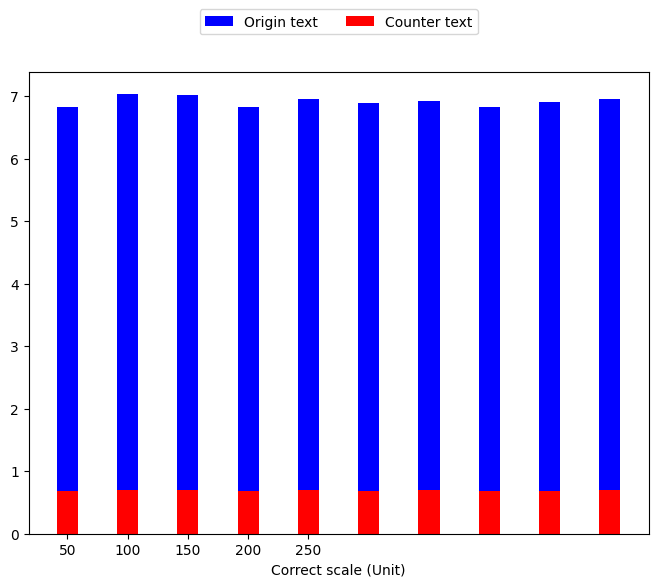

In [123]:
iterations = metrics_log['iterations']
text_quality = metrics_log['text_quality']
text_quality = [n*10 for n in text_quality]
counter_text = metrics_log['Counter_text']
frame_rate = [n/100 for n in frame_rate]

bar_width = 0.35
epcohs = 10
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(iterations, text_quality, color='blue', width=bar_width, label='Origin text')
ax.bar(iterations, counter_text, color='red', width=bar_width, label='Counter text')

ax.set_xlabel("Correct scale (Unit)")
ax.set_xticks(epochs)
ax.set_xticklabels([str(i*50) for i in epochs])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.show()